<a href="https://colab.research.google.com/github/asengardeon/reinforcement_learning/blob/developer/Reinforcemente_Learning_carregar_objeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTS**

In [6]:
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import gym
from gym import spaces
import numpy as np
from datetime import datetime

**QLEARNING**

In [7]:

def Qlearning(environment, num_episodes=100, alpha=0.3, gamma=0.9, epsilon=1.0, decay_epsilon=0.1, max_epsilon=1.0,
              min_epsilon=0.01):
    # initializing the Q-table
    Q = np.zeros((environment.observation_space.n, environment.action_space.n))

    # additional lists to keep track of reward and epsilon values
    rewards = []
    epsilons = []

    print_count = 0
    # episodes
    for episode in range(num_episodes):

        # reset the environment to start a new episode
        state = environment.reset()

        # reward accumulated along episode
        accumulated_reward = 0

        # steps within current episode
        for step in range(300):

            # epsilon-greedy action selection
            # exploit with probability 1-epsilon
            if np.random.uniform(0, 1) > epsilon:
                action = np.argmax(Q[state, :])

            # explore with probability epsilon
            else:
                action = environment.action_space.sample()

            # perform the action and observe the new state and corresponding reward
            new_state, reward, done, info = environment.step(action)

            # update the Q-table
            Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])

            # update the accumulated reward
            accumulated_reward += reward

            # update the current state
            state = new_state

            # end the episode when it is done
            if done == True:
                break

        # decay exploration rate to ensure that the agent exploits more as it becomes experienced
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_epsilon * episode)

        # update the lists of rewards and epsilons
        rewards.append(accumulated_reward)
        epsilons.append(epsilon)
        environment.print_infos(episode, accumulated_reward)


    # render the environment
    environment.render()

    # return the list of accumulated reward along episodes
    return rewards

**ENVIRONMENT**

In [8]:
import math
import tkinter.filedialog
from copy import deepcopy

import numpy as np
import gym
from gym import spaces

class MyEnv(gym.Env):
  metadata = {'render.modes': ['console']}

  # Define constants for clearer code
  LEFT = 0
  RIGHT = 1
  UP = 2
  DOWN = 3



  def __init__(self):
      super(MyEnv, self).__init__()

      # Size of the 1D-grid
      self.columns = 7
      self.rows = 6
      self.start = [5, 0]
      self.objeto_state = [2, 3]
      # Initialize the agent at the right of the grid
      self.agent_pos = (5,0) #linha, coluna
      self.objeto = (2, 3) #linha, coluna
      self.paredes = [(1, 3), (4,0), (4, 1), (4, 3), (4, 4), (4, 5), (4, 6), (5, 6)]
      self.base = [(0, 2), (0, 3), (0, 4)]
      self.matriz_renderizacao = [["" for x in range(7)] for y in range(6)]
      self.capturou_objeto = False

      # Define action and observation space
      # They must be gym.spaces objects
      # Example when using discrete actions, we have two: left and right
      n_actions = 4
      self.action_space = spaces.Discrete(n_actions)

      self.current_state = None
      # The observation will be the coordinate of the agent
      # this can be described both by Discrete and Box space
      self.observation_space = spaces.Discrete(self.rows*self.columns)


  def observation(self, state):
      return state[0] * self.columns + state[1]


  def colidiu(self, x, y):
      if x < 0 or y < 0 or x >= self.columns or y >= self.rows:
          return True
      if (y, x) == self.objeto:
          return True
      if (y, x) in self.paredes:
          return True

      return False

  def pode_andar(self, x, y, action):
      colide = self.colidiu(x, y)
      if colide:
          return False
      if self.capturou_objeto:
          new_x, new_y = self.get_delta(self.objeto_state, action)
          colide = self.colidiu(new_x, new_y)
          if colide:
              return False
      return True


  def captura_objeto(self):
      y = self.current_state[0]
      x = self.current_state[1]
      if y == 2 and x in [2,4]:
          self.capturou_objeto = True


  def get_delta(self, state_array, action):
      new_x = state_array[1]
      new_y = state_array[0]

      if action == self.RIGHT:  # right
          new_x = new_x + 1
      elif action == self.DOWN:  # down
          new_y = new_y + 1
      elif action == self.LEFT:  # left
          new_x = new_x - 1
      elif action == self.UP:  # up
          new_y = new_y - 1
      else:
          raise Exception("Invalid action.")

      return new_x, new_y

  def step(self, action):
      new_state = deepcopy(self.current_state)
      new_x, new_y = self.get_delta(new_state, action)
      new_x_o, new_y_o = self.get_delta(self.objeto_state, action)

      andou = self.pode_andar(new_x, new_y, action)
      new_state = [new_y, new_x] if andou else new_state
      if self.capturou_objeto:
        self.objeto_state = [new_y_o, new_x_o] if andou else self.objeto_state

      self.current_state = new_state
      self.captura_objeto()

      reward = -1.0
      is_terminal = False


      if andou:
          if (self.objeto_state[0], self.objeto_state[1]) in self.base:
              if self.capturou_objeto: #se chegou na base sem o objeto
                  is_terminal = True
                  reward = 1
              else:
                  reward = -100.0
                  self.current_state = deepcopy(self.start)

      return self.observation(self.current_state), reward, is_terminal, {}


  def reset(self):
    self.agent_pos = (5,0)
    self.objeto = (2, 3)
    self.current_state = self.start
    self.objeto_state = [2, 3]
    self.capturou_objeto = False
    return self.observation(self.current_state)


  def render(self, mode='console'):
    if mode != 'console':
       raise NotImplementedError()
       # agent is represented as a cross, rest as a dot
    ay, ax = self.current_state[0], self.current_state[1]
    oy, ox = self.objeto_state[0], self.objeto_state[1]

    for y, x in self.paredes:
        self.matriz_renderizacao[y][x] = "X"
    for y, x in self.base:
        self.matriz_renderizacao[y][x] = "B"

    for y in range(self.rows):
        for x in range(self.columns):
            if not self.matriz_renderizacao[y][x] in ["X", "B"]:
                if ax == x and ay == y:
                    self.matriz_renderizacao[y][x] = "A"
                elif ox == x and oy == y:
                    self.matriz_renderizacao[y][x] = "O"
                else:
                    self.matriz_renderizacao[y][x] = " "

    for y in range(self.rows):
        print("-" * self.columns * 2)
        linha = "|"
        for x in range(self.columns):
            linha += f"{self.matriz_renderizacao[y][x]}|"
        print(linha)


  def print_infos(self, step, accumulated_reward):
      print(f"[{step}] = agente: {self.current_state} - objeto: {self.objeto_state} accumulated_reward: {accumulated_reward}")
      # print(f"objeto: {self.objeto_state}")


  def close(self):
    pass

**EXECUTE**

In [9]:

def execute():
    num_episodes = 300
    alpha = 0.3
    gamma = 0.9
    epsilon = 1.0
    decay_epsilon = 0.3

    env = MyEnv()
    # run Q-learning
    t1 = datetime.now()
    rewards = Qlearning(env, num_episodes, alpha, gamma, epsilon, decay_epsilon)
    t2 = datetime.now() - t1
    # print results
    print("Average reward (all episodes): " + str(sum(rewards) / num_episodes))
    print("Average reward (last 10 episodes): " + str(sum(rewards[-10:]) / 10))
    print(f"Time execution: {t2}")
    t2

    plt.plot(range(num_episodes), rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Accumulated reward along episodes')
    plt.show()

# Press the green button in the gutter to run the script.


**MAIN**

[0] = agente: [0, 3] - objeto: [0, 4] accumulated_reward: -102.0
[1] = agente: [0, 5] - objeto: [0, 4] accumulated_reward: -267.0
[2] = agente: [0, 5] - objeto: [0, 4] accumulated_reward: -46.0
[3] = agente: [0, 1] - objeto: [0, 2] accumulated_reward: -64.0
[4] = agente: [0, 1] - objeto: [0, 2] accumulated_reward: -28.0
[5] = agente: [0, 1] - objeto: [0, 2] accumulated_reward: -95.0
[6] = agente: [0, 5] - objeto: [0, 4] accumulated_reward: -38.0
[7] = agente: [0, 1] - objeto: [0, 2] accumulated_reward: -34.0
[8] = agente: [0, 1] - objeto: [0, 2] accumulated_reward: -20.0
[9] = agente: [0, 1] - objeto: [0, 2] accumulated_reward: -24.0
[10] = agente: [0, 1] - objeto: [0, 2] accumulated_reward: -42.0
[11] = agente: [0, 5] - objeto: [0, 4] accumulated_reward: -31.0
[12] = agente: [0, 1] - objeto: [0, 2] accumulated_reward: -62.0
[13] = agente: [0, 1] - objeto: [0, 2] accumulated_reward: -13.0
[14] = agente: [0, 1] - objeto: [0, 2] accumulated_reward: -30.0
[15] = agente: [0, 1] - objeto: [

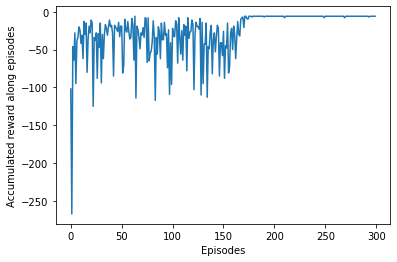

In [10]:
execute()